In [ ]:
import torch
import matplotlib.pyplot as plt
import json
import 

In [92]:
HEIGHT = 1080
WIDTH = 1920
def vitpose_preprocess(pose_feature):
    P, T, J, _ = pose_feature.shape
    # keep only estimates that are greater than zero
    pose_feature_filtered = torch.zeros(pose_feature.shape)
    pose_feature_filtered[pose_feature[:,:,:,-1]>0.5] = pose_feature[pose_feature[:,:,:,-1]>0.5]
    pose_feature_filtered = pose_feature_filtered[:,:,:,:2] # keep only y/x coordinates
    # normalize height and width to 0-1
    pose_feature_filtered[:,:,:,0] /= HEIGHT
    pose_feature_filtered[:,:,:,1] /= WIDTH

    # Merge persons: if not 2 skeletons are detected, keep first valid one; otherwise, choose first person
    processed_pose = torch.zeros((T, J, 2))  # output shape: (T, J, 2)
    for t in range(T):
        # Find persons with valid keypoints at time t
        valid_persons = []
        for p in range(P):
            if torch.any(pose_feature_filtered[p, t] != 0):
                valid_persons.append(p)
        #take the first valid person 
        if len(valid_persons) >= 1:
            processed_pose[t] = pose_feature_filtered[valid_persons[0], t]

    return processed_pose  # shape: (T, J, 2)

def plot_kpts(keypoints, t):
    plt.figure(figsize=(6, 6))
    # Plot keypoints with labels
    plt.plot(keypoints[t, :, 1], keypoints[t, :, 0], "k.", markersize=5)
        
    for j in range(keypoints.shape[1]):
        x, y = keypoints[t, j, 1], keypoints[t, j, 0]
        plt.text(x + 1e-10, y + 1e-10, str(j), fontsize=10, color="k", alpha=0.7)

    # Emphasize specific joints
    for j in [0]:
        plt.plot(keypoints[t, j, 1], keypoints[t, j, 0], "k.", markersize=10)
    for j in [15, 16]:
        plt.plot(keypoints[t, j, 1], keypoints[t, j, 0], "k.", markersize=10)
    for j in [9, 10]:
        plt.plot(keypoints[t, j, 1], keypoints[t, j, 0], "k.", markersize=10)


    # Draw skeleton connections

    for joint in skeleton:
        start, end = joint
        plt.plot(
            [keypoints[t, start, 1], keypoints[t, end, 1]],
            [keypoints[t, start, 0], keypoints[t, end, 0]],
            color="k",
        )

    plt.gca().invert_yaxis()  # Optional: flip y-axis if coordinates are image-style
    plt.axis("equal")
    plt.title(f"Skeletons at frame {t}")
    plt.show()

In [86]:
keypoints = torch.load("/data/han_data/dance_data/prixdelausanne_vitpose_tensor/999_2dkeypoints.pkl") # imgsize(1080, 1920, 3)

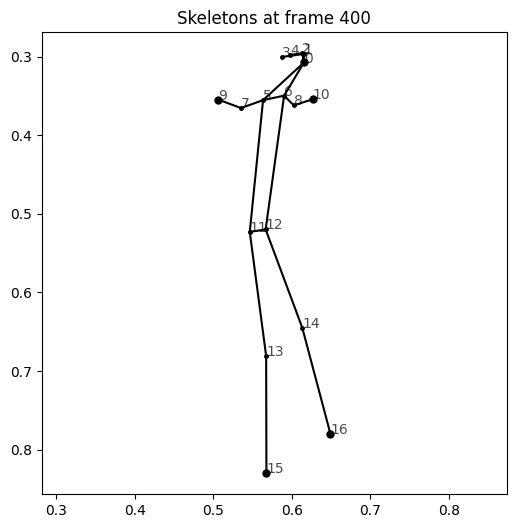

In [93]:
post_keypoints = vitpose_preprocess(keypoints) #(T,J,2)
plot_kpts(post_keypoints,t=400)

In [48]:
torch.max(post_keypoints), torch.min(post_keypoints)

(tensor(1.0000), tensor(-0.0018))

In [ ]:
keypoints_filtered = torch.zeros(keypoints.shape)
keypoints_filtered[keypoints[:,:,:,-1] > 0.5] = keypoints[keypoints[:,:,:,-1] > 0.5]



print(torch.max(torch.max(keypoints_filtered[0], dim=0).values, dim=0))
print(torch.min(torch.min(keypoints_filtered[0], dim=0).values, dim=0))
print(torch.mean(torch.mean(keypoints_filtered[0], dim=0), dim=0))

torch.return_types.max(
values=tensor([1.0680e+03, 1.9199e+03, 1.0902e+00]),
indices=tensor([6, 3, 4]))
torch.return_types.min(
values=tensor([ 0.0000, -3.4308,  0.0000]),
indices=tensor([0, 9, 0]))
tensor([3.5187e+02, 5.8904e+02, 5.1734e-01])


In [36]:
print(torch.max(torch.max(keypoints[0], dim=0).values, dim=0))
print(torch.min(torch.min(keypoints[0], dim=0).values, dim=0))
print(torch.mean(torch.mean(keypoints[0], dim=0), dim=0))

torch.return_types.max(
values=tensor([7.8634e+03, 1.9745e+03, 1.0902e+00]),
indices=tensor([12,  5,  4]))
torch.return_types.min(
values=tensor([   0.0000, -414.6042,    0.0000]),
indices=tensor([0, 5, 0]))
tensor([3.9586e+02, 6.5958e+02, 5.2450e-01])


In [ ]:
keypoints.shape, torch.max(keypoints[:,:,:,:2]), torch.min(keypoints[:,:,:,:2])

(torch.Size([2, 2504, 17, 3]), tensor(301.7271), tensor(301.7271))

(-414.604248046875, 1974.50537109375)

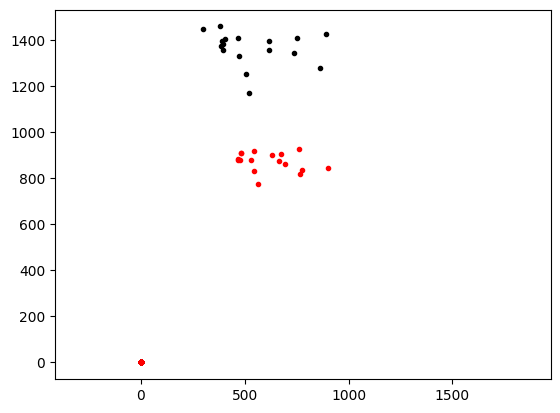

In [19]:
p = 0
for p in [0,1]:
    frame = keypoints[p, 300, :, :2]
    plt.plot(frame[:,0],frame[:,1], "k.")
    frame2 = keypoints[p, 400, :, :2]
    plt.plot(frame2[:,0],frame2[:,1], "r.")
xmin, xmax = torch.min(keypoints[:,:,:,0]), torch.max(keypoints[:,:,:,0])
ymin, ymax = torch.min(keypoints[:,:,:,1]), torch.max(keypoints[:,:,:,1])
plt.xlim([xmin, xmax])
plt.xlim([ymin, ymax])

In [20]:
keypoints[0, 0, :, 2], keypoints[1, 0, :, 1]

(tensor([0.7872, 0.9244, 0.9330, 0.0888, 0.1471, 0.0069, 0.0177, 0.0131, 0.0347,
         0.0366, 0.1105, 0.0138, 0.0220, 0.1798, 0.1797, 0.0161, 0.0164]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [70]:
present_firstperson = []
present_secondperson = []
absent_firstperson = []
absent_secondperson = []
for t in range(keypoints.shape[1]):
    #print(torch.sum(keypoints[0, t, :, :2]), torch.sum(keypoints[1, t, :, :2]))
    if torch.sum(keypoints[0, t, :, :2])!=0:
        present_firstperson.append(t)
    else:
        absent_firstperson.append(t)
    if torch.sum(keypoints[1, t, :, :2])!=0:
        present_secondperson.append(t)
    else:
        absent_secondperson.append(t)
both = set(present_firstperson).intersection(present_secondperson)

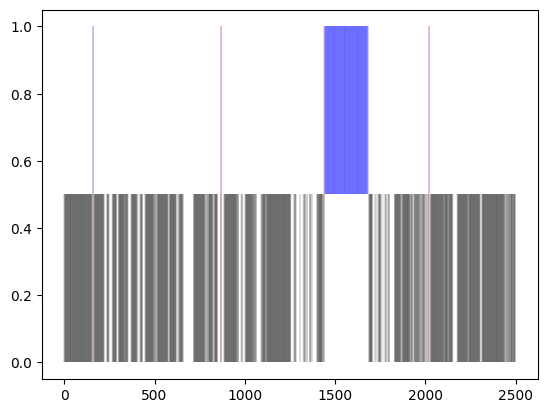

In [72]:
plt.vlines(present_firstperson, colors="k", ymax=0.5,ymin=0, linewidth=0.1)
plt.vlines(present_secondperson, colors="b", ymax=1,ymin=0.5, linewidth=0.1)
plt.vlines(list(both), colors="r", ymax=1,ymin=0, linewidth=0.1)
#plt.plot(present_secondperson, "r.")

In [77]:
both

{157, 870, 871, 1440, 2020, 2021}

In [83]:
import json
with open("/data/han_data/dance_data/prixdelausanne_vitpose/0_2dkeypoints.json", "r") as read_file:
    skeleton = json.load(read_file)["skeleton"] # a list of {person_id: (17,3)} dictionaries

In [49]:
skeleton=[
            [15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12],
            [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1],
            [0, 2], [1, 3], [2, 4], [0, 5], [0, 6]
            ]
    

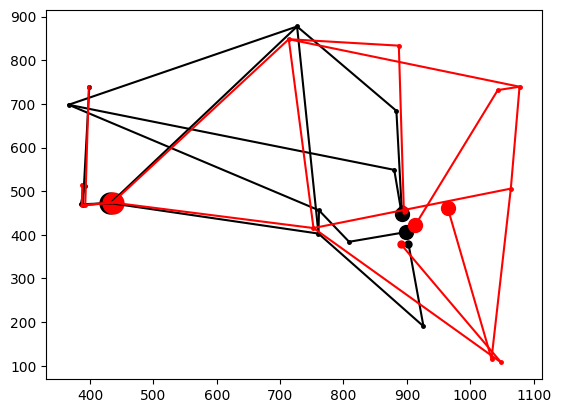

In [132]:
t = 157
plt.plot(keypoints[0,t, :, 0], keypoints[0,t, :, 1], "k.", markersize=5)
plt.plot(keypoints[1,t, :, 0], keypoints[1,t, :, 1], "r.", markersize=5)
for j in [0]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0,t, j, 1], "k.", markersize=30)
    plt.plot(keypoints[1, t, j, 0], keypoints[1,t, j, 1], "r.", markersize=30)
for j in [15, 16]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0,t, j, 1], "k.", markersize=20)
    plt.plot(keypoints[1, t, j, 0], keypoints[1,t, j, 1], "r.", markersize=20)
for j in [9, 10]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0,t, j, 1], "k.", markersize=10)
    plt.plot(keypoints[1, t, j, 0], keypoints[1,t, j, 1], "r.", markersize=10)
colors = ["k", "r"]
for p in [0,1]:
    for joint in skeleton:
        # connect the lines
        start, end = joint
        plt.plot([keypoints[p, t, start, 0], keypoints[p, t, end, 0]], 
                [keypoints[p, t, start, 1], keypoints[p, t, end, 1]], color=colors[p])

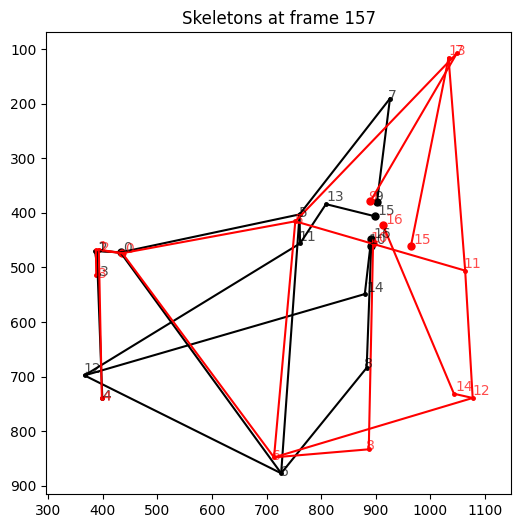

In [133]:
import numpy as np
t = 157
plt.figure(figsize=(6, 6))
offset_radius = 5  # Distance between dot and label
angle_offsets = np.linspace(0, 2 * np.pi, keypoints.shape[2], endpoint=False)

# Plot keypoints with labels
for p, color in zip([0, 1], ["k", "r"]):
    plt.plot(keypoints[p, t, :, 0], keypoints[p, t, :, 1], f"{color}.", markersize=5)
    
    for j in range(keypoints.shape[2]):
        x, y = keypoints[p, t, j, 0], keypoints[p, t, j, 1]
        angle = angle_offsets[j]
        dx = offset_radius * np.cos(angle)
        dy = offset_radius * np.sin(angle)
        plt.text(x + dx, y + dy, str(j), fontsize=10, color=color, alpha=0.7)

# Emphasize specific joints
for j in [0]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0, t, j, 1], "k.", markersize=10)
    plt.plot(keypoints[1, t, j, 0], keypoints[1, t, j, 1], "r.", markersize=10)
for j in [15, 16]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0, t, j, 1], "k.", markersize=10)
    plt.plot(keypoints[1, t, j, 0], keypoints[1, t, j, 1], "r.", markersize=10)
for j in [9, 10]:
    plt.plot(keypoints[0, t, j, 0], keypoints[0, t, j, 1], "k.", markersize=10)
    plt.plot(keypoints[1, t, j, 0], keypoints[1, t, j, 1], "r.", markersize=10)

# Draw skeleton connections
colors = ["k", "r"]
for p in [0, 1]:
    for joint in skeleton:
        start, end = joint
        plt.plot(
            [keypoints[p, t, start, 0], keypoints[p, t, end, 0]],
            [keypoints[p, t, start, 1], keypoints[p, t, end, 1]],
            color=colors[p],
        )

plt.gca().invert_yaxis()  # Optional: flip y-axis if coordinates are image-style
plt.axis("equal")
plt.title(f"Skeletons at frame {t}")
plt.show()


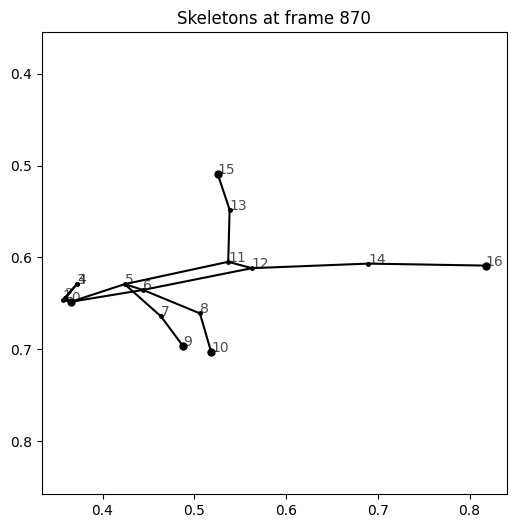

In [ ]:
t = 870
def plot_kts(keypoints, t):
    plt.figure(figsize=(6, 6))
    # Plot keypoints with labels
    plt.plot(keypoints[t, :, 0], keypoints[t, :, 1], "k.", markersize=5)
        
    for j in range(keypoints.shape[1]):
        x, y = keypoints[t, j, 0], keypoints[t, j, 1]
        plt.text(x + 1e-10, y + 1e-10, str(j), fontsize=10, color="k", alpha=0.7)

    # Emphasize specific joints
    for j in [0]:
        plt.plot(keypoints[t, j, 0], keypoints[t, j, 1], "k.", markersize=10)
    for j in [15, 16]:
        plt.plot(keypoints[t, j, 0], keypoints[t, j, 1], "k.", markersize=10)
    for j in [9, 10]:
        plt.plot(keypoints[t, j, 0], keypoints[t, j, 1], "k.", markersize=10)


    # Draw skeleton connections

    for joint in skeleton:
        start, end = joint
        plt.plot(
            [keypoints[t, start, 0], keypoints[t, end, 0]],
            [keypoints[t, start, 1], keypoints[t, end, 1]],
            color="k",
        )

    plt.gca().invert_yaxis()  # Optional: flip y-axis if coordinates are image-style
    plt.axis("equal")
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title(f"Skeletons at frame {t}")
    plt.show()
